In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
def fetch_trades(pair):
    all_trades = []
    current_page = 1
    total_pages = 1  # Se asume al menos una pagina al iniciar

    while current_page <= total_pages:
        url = f"https://api.ripiotrade.co/v4/public/trades?pair={pair}&current_page={current_page}"
        response = requests.get(url)
        print(f"Fetching page {current_page}: {response.status_code}")

        if response.status_code == 200:
            data = response.json()['data']
            all_trades.extend(data['trades'])
            total_pages = data['pagination']['total_pages']  # Se actualiza el total de paginas del response
            current_page += 1
        else:
            print(f"Failed to fetch page {current_page}. Status code: {response.status_code}")
            break

    return all_trades

def process_trades(trades):
    df = pd.DataFrame(trades)
    df['date'] = pd.to_datetime(df['date']).dt.date
    df['price'] = df['price'].astype(float)
    df['amount'] = df['total_value'].astype(float)
    
    # Se agrupa la OHLC data y volumen buy/sell 
    ohlc = df.groupby('date').agg(
        open=('price', 'first'),
        high=('price', 'max'),
        low=('price', 'min'),
        close=('price', 'last'),
        avg=('price', 'mean'),
        trade_count=('date', 'size'),  
    )
    ohlc['volume_buy'] = df[df['maker_side'] == 'buy'].groupby('date')['amount'].sum()
    ohlc['volume_sell'] = df[df['maker_side'] == 'sell'].groupby('date')['amount'].sum()
    ohlc['volume_total'] = df.groupby('date')['amount'].sum()
    
    ohlc.fillna(0, inplace=True)
    return ohlc

def create_close_price_chart(df,token):
    # Nos aseguramos que el indice este en formato datetime (si es que ya no esta)
    df.index = pd.to_datetime(df.index)
    
    # Ploteamos el Close price con los labels en cada punto
    fig1, ax1 = plt.subplots(figsize=(14, 7))
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Precio de cierre')
    ax1.plot(df.index, df['close'], color='tab:red', label='Precio de cierre', marker='o')
    ax1.tick_params(axis='y')
    ax1.ticklabel_format(style='plain', axis='y')  
    
    # Agregamos los labels del precio x día
    for i in range(len(df)):
        ax1.text(df.index[i], df['close'][i], f'${df["close"][i]:,.5f}', ha='center', va='bottom')

    plt.title(f"{token} - Precio de cierre x día")
    plt.show()

def create_volume_chart(df,token):
    df.index = pd.to_datetime(df.index)
    # Ploteamos el volumen con labels
    fig2, ax2 = plt.subplots(figsize=(14, 7))
    bars1 = ax2.bar(df.index, df['volume_buy'], label='Buy', color='green', alpha=0.6)
    bars2 = ax2.bar(df.index, df['volume_sell'], bottom=df['volume_buy'], label='Sell', color='red', alpha=0.6)
    ax2.ticklabel_format(style='plain', axis='y')  # Use plain number format
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel('Volumen')
    
    # Agregamos los labels
    for bar1, bar2 in zip(bars1, bars2):
        height = bar1.get_height() + bar2.get_height()
        label = f'${height:,.0f}'  
        ax2.text(bar1.get_x() + bar1.get_width() / 2.0, height, label, ha='center', va='bottom')
    
    plt.legend(loc='upper left')
    plt.title(f"{token} - Volumen diario en Ripio (Buy/Sell)")
    plt.show()

In [27]:
#### Analisis de MAGAIBA ####
token = "MAGAIBA"
pair = "MAGAIBA_UXD"
trades_magaiba = fetch_trades(pair)
ohlc_vol_magaiba = process_trades(trades_magaiba)
print(ohlc_vol_magaiba)

Fetching page 1: 200
Fetching page 2: 200
Fetching page 3: 200
Fetching page 4: 200
                open     high       low     close       avg  trade_count  \
date                                                                       
2024-03-14  0.006500  0.01153  0.005999  0.011530  0.008543          159   
2024-03-15  0.005000  0.00650  0.003800  0.006500  0.005057          156   
2024-03-16  0.002990  0.00550  0.002000  0.005000  0.003986          134   
2024-03-17  0.001965  0.00300  0.001058  0.002500  0.001902           51   
2024-03-18  0.003000  0.00300  0.002200  0.002992  0.002832          137   
2024-03-19  0.002300  0.00305  0.002200  0.003000  0.002618           54   

             volume_buy  volume_sell  volume_total  
date                                                
2024-03-14  2763.511594  2067.440304   4830.951898  
2024-03-15  3202.532878  3015.367844   6217.900722  
2024-03-16  3762.596282   251.028430   4013.624712  
2024-03-17  1286.778948    41.389806   132

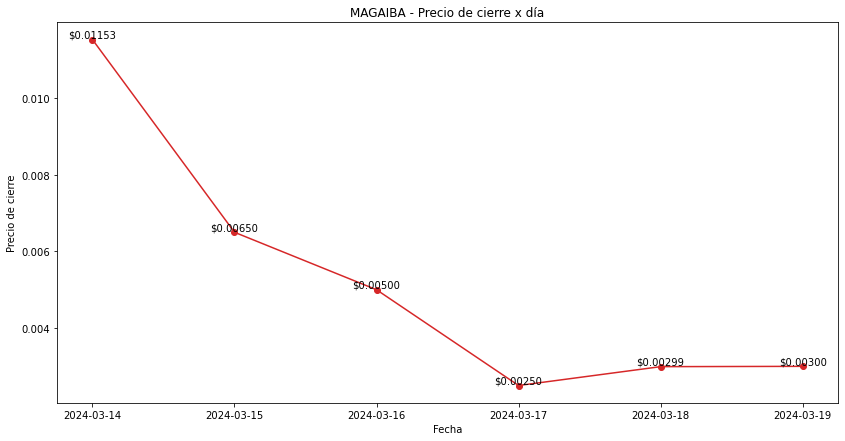

In [29]:
create_close_price_chart(ohlc_vol_magaiba, token)

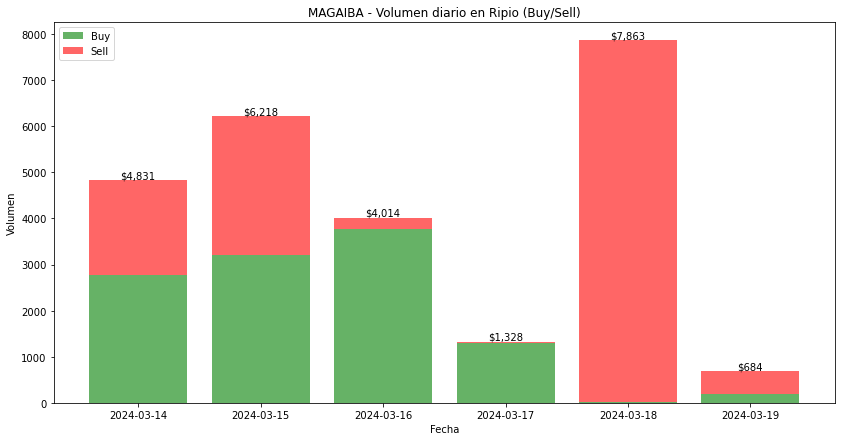

In [28]:
create_volume_chart(ohlc_vol_magaiba,token)

In [30]:
#### Analisis de SOL ####
token = "SOLANA"
pair = "SOL_UXD"
trades_sol = fetch_trades(pair)
ohlc_vol_sol = process_trades(trades_sol)
print(ohlc_vol_sol)

Fetching page 1: 200
              open    high     low   close         avg  trade_count  \
date                                                                  
2024-03-14  177.85  450.00    1.00    1.00  170.354828           29   
2024-03-15  176.01  182.78  168.54  177.85  178.883913           23   
2024-03-16  182.25  193.54  181.58  181.58  185.790000            3   
2024-03-17  203.58  203.58  182.99  186.33  195.508421           19   
2024-03-18  198.24  208.87  196.55  208.87  200.961818           33   
2024-03-19  185.17  196.77  173.79  196.55  183.795278           36   

            volume_buy  volume_sell  volume_total  
date                                               
2024-03-14      818.53      2080.73       2899.26  
2024-03-15      532.74       546.08       1078.82  
2024-03-16       27.54        62.46         90.00  
2024-03-17      770.85       486.20       1257.05  
2024-03-18     1404.65      2743.09       4147.74  
2024-03-19     2217.94      1768.36       3986

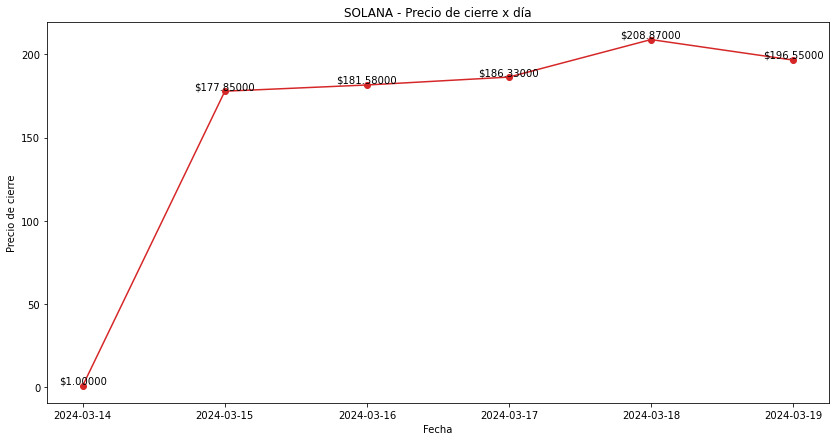

In [31]:
create_close_price_chart(ohlc_vol_sol, token)

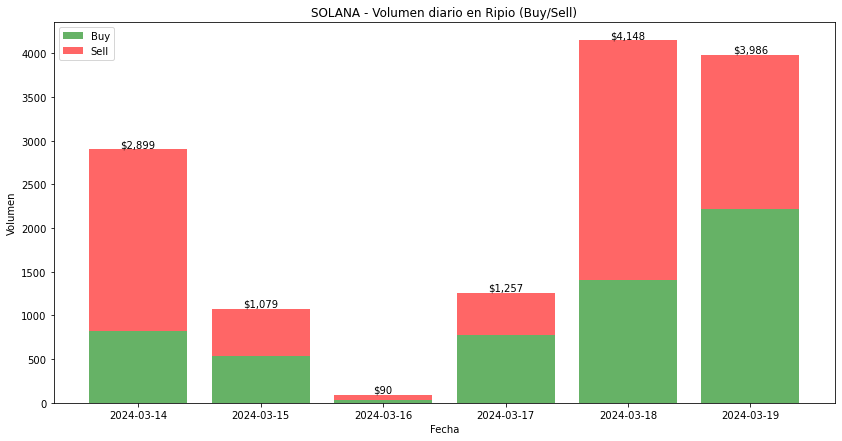

In [32]:
create_volume_chart(ohlc_vol_sol,token)